# CTD casts

In [1]:
import os, sys, pickle, glob
#import csv
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import copy

import datetime

import pandas as pd

# cognac data and tools
import cognac.insitu as insi

---

# load and clean data

In [2]:
# data directory and filename
#
#data_dir = '../data/ctd/'
cp = insi.utils.campaign('microco_leg2.yaml')
data_dir = cp.path+'ctd/'

casts = [2, 3, 4, 5]

files = [data_dir+'CTD'+str(c)+'.cnv' for c in casts]
_ = [print(f) for f in files]

/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/ctd/CTD2.cnv
/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/ctd/CTD3.cnv
/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/ctd/CTD4.cnv
/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/ctd/CTD5.cnv


In [3]:
d = insi.ctd.ctd(files[0])
d.d.head()
#(d['pressure'].diff()/d.dt).plot()

,pressure,temperature,salinity,conductivity,flag
time,,,,,
2018-09-11 07:42:16.125,-0.379,23.9204,0.7355,1.435889,0.0
2018-09-11 07:42:16.250,-0.379,23.9702,0.7314,1.429612,0.0
2018-09-11 07:42:16.375,-0.205,23.9673,0.7280,1.423144,0.0
2018-09-11 07:42:16.500,-0.379,23.9657,0.7240,1.415718,0.0
2018-09-11 07:42:16.625,-0.379,23.9638,0.7199,1.407942,0.0


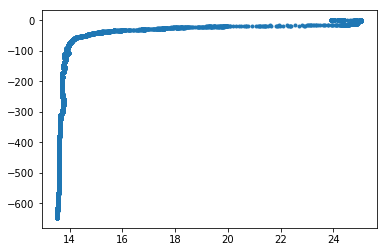

In [4]:
plt.figure()
plt.plot(d['temperature'],-d['pressure'],'.')

In [5]:
d.resample('1S')

In [6]:
d.clean_and_depthbin()

In [7]:
d.d.head()

,temperature,salinity,conductivity,flag
pressure,,,,
0.0,24.911188,38.063100,57.070921,0.0
1.0,24.907232,38.336042,57.428868,0.0
2.0,24.907350,38.342521,57.437747,0.0
3.0,24.902844,38.383269,57.487318,0.0
4.0,24.902100,38.383300,57.486998,0.0


In [8]:
d.plot_bk()

Loading BokehJS ...

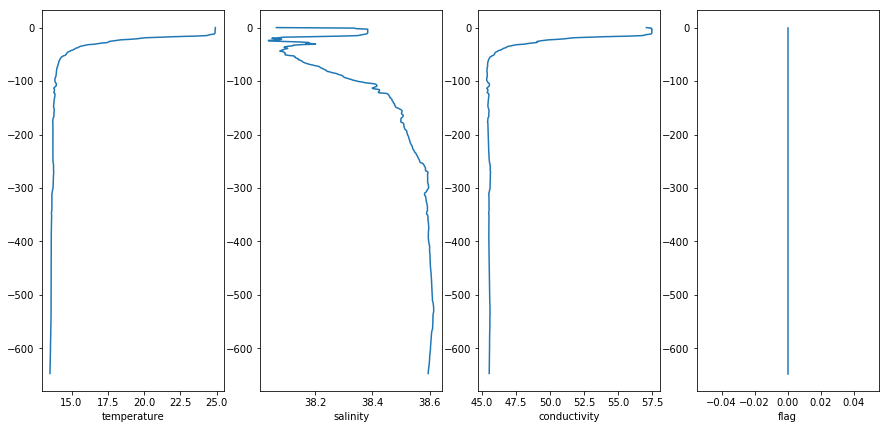

In [10]:
d.plot()

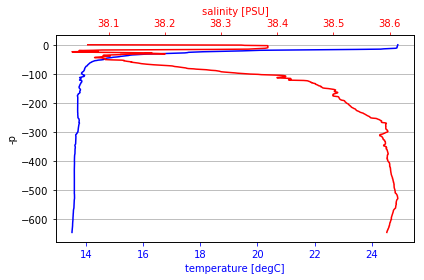

In [11]:
fig, ax1 = plt.subplots()
ax1.plot(d['temperature'], -d['pressure'], 'b-')
ax1.set_xlabel('temperature [degC]', color='b')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('-p')
ax1.tick_params('x', colors='b')

ax2 = ax1.twiny()
ax2.plot(d['salinity'], -d['pressure'], 'r-')
ax2.set_xlabel('salinity [PSU]', color='r')
ax2.tick_params('x', colors='r')

ax1.yaxis.grid()
fig.tight_layout()
plt.show()


---
# process all casts

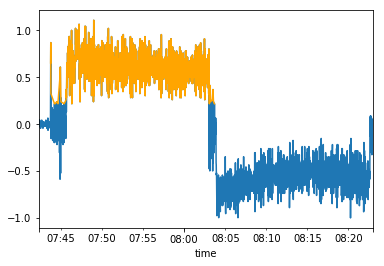

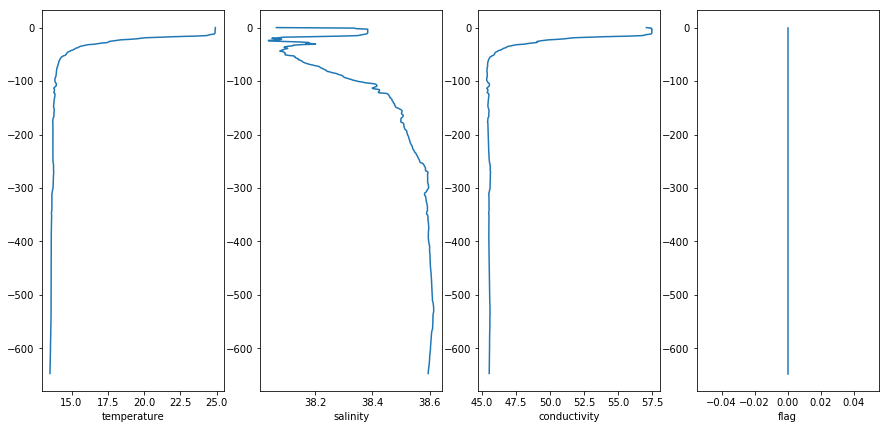

Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/ctd_02.p


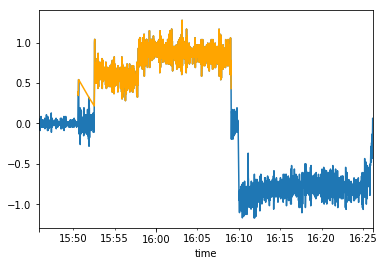

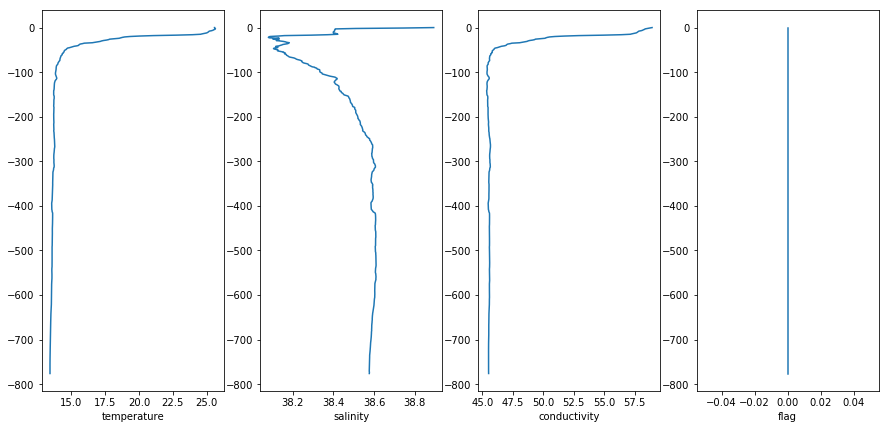

Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/ctd_03.p


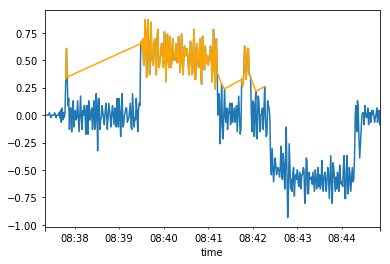

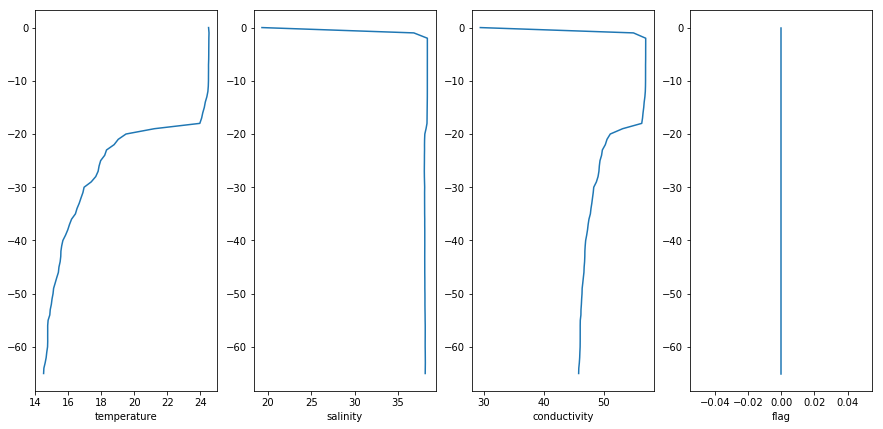

Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/ctd_04.p


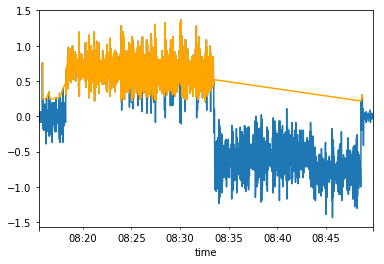

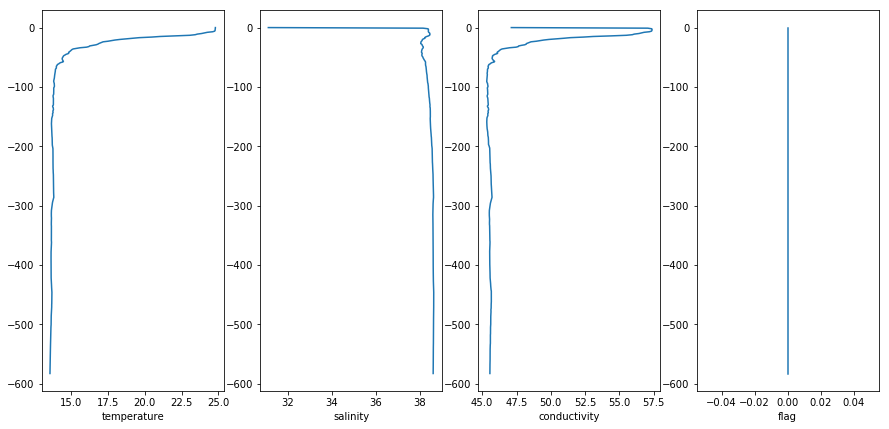

Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/ctd_05.p


In [12]:
for c, file in zip(casts, files):
    d = insi.ctd.ctd(file)
    d.resample('1S')
    d.clean_and_depthbin(plot=True)
    d.plot()
    #d.plot_bk()
    d.to_pickle(cp.pathp+'ctd_%02d.p'%c)


---

In [14]:
%load_ext autoreload

In [15]:
# Reload all modules (except those excluded by %aimport) automatically now.
%autoreload 2
#from data import *